In [1]:
from minimal_model import insulin_clamp_dynamic, ref_parameters, TAU_INS, equation, fluxes, REF_STEADY_STATE_VALUES
import numpy as np

In [2]:
# Compute ref insulin value
k = 3.4
C = 2.3
I0 = abs(1.0)**k / (abs(1.0)**k + C**k)

In [3]:
# Test model 
x0=[1.0,1.0,1.0,1.0,I0,I0]
equation(x0,1,ref_parameters())

# Check if fluxes are correct
fluxes(x0,1,ref_parameters())[:10] - REF_STEADY_STATE_VALUES[:10]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [4]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator


# Set font size and style in matplotlib
plt.rcParams.update({'font.size': 12, 'font.family': 'Arial'})

# Error bar kwargs for prism style plots
errorbar_kwargs = {'capsize': 2, 'capthick': 1, 'elinewidth': 1, 'zorder': 10}

# Spine properties
spine_properties = {'color': 'black', 'linewidth': 2}

# TODO Better colors for this figure

# Color palate with basal, default, and perturbation colors
colors_basal = ['whitesmoke','lightsteelblue', 'steelblue']

# Color palate default, perturbation
colors_default = ['lightsteelblue', 'steelblue']


# Palatte for insulin resitance panels (Baseline, Insulin, Inuslin + Perturbation)
palette = ['#8E8E8E' ,'#C959C5', '#4FC452', ]


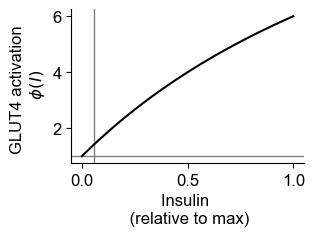

In [5]:
# Plot insulin activation function 

I = np.linspace(0,1,100)

KA_glut4 = 2
phi =  1 + 5 * I / (I + KA_glut4 ) * (KA_glut4 + 1)


# Plot 
fig, ax = plt.subplots(1,1, figsize=(3,2))

# Vertical line at I0
plt.axvline(I0, color='grey', linestyle='-', label='I0', linewidth=1)   
# Horizontal line at 1
plt.axhline(1, color='grey', linestyle='-', label='1', linewidth=1)

plt.plot( I, phi, label='Activation function', linewidth=1.5, color='black')  

plt.xlabel('Insulin \n (relative to max)')
plt.ylabel('GLUT4 activation \n $\phi(I)$')
sns.despine()
#plt.ylim((0,2))

plt.savefig('output/insulin_activation_function.svg', bbox_inches='tight')

In [6]:
time = np.linspace(0,120,100)

vI_low = I0/TAU_INS # Double basal fasted insulin levles
vI_high = I0/TAU_INS * 3 # Two time low dose

In [7]:
# ATP per O2 (3 per O)
PO2 = 5.0
# Whole body oxygen consumption rate ~ 2000 nmol/min/gBW
vO2 = 2000 * 0.7 
# ATP production rate
vATP = PO2 * vO2 
# Scale the oxygen fluxes by vE
vE = vATP 

# GIR scaling 
sGIR = vE * 180 * 1e-3

# Infusion rates for the perurbative infusions 

# 3HB 
sK =  14/27
v_in_K = 120/vE * sK

# Lactate
sL = 200/150
v_in_L = 130.5/vE * sL

In [8]:
# Load all the experimental data

# Glucose infusion rate
GIR_clamp_intralipid = pd.read_csv('data/Intralipid_clamp_insulin_dose_GIR.csv',index_col=0) \
                            .melt(ignore_index=False).reset_index()\
                            .rename(columns={'index':'time', 'value':'GIR'}).dropna()

GIR_clamp_3HB = pd.read_csv('data/3HB_clamp_insulin_dose_GIR.csv',index_col=0) \
                            .melt(ignore_index=False).reset_index()\
                            .rename(columns={'index':'time', 'value':'GIR'}).dropna()

GIR_clamp_lactate = pd.read_csv('data/Lactate_clamp_insulin_dose_GIR.csv',index_col=0) \
                            .melt(ignore_index=False).reset_index()\
                            .rename(columns={'index':'time', 'value':'GIR'}).dropna()

# Fatty acids 
FFA_clamp_intralipid = pd.read_csv('data/Intralipid_clamp_insulin_dose_FFA.csv', index_col=0)\
                        .melt(ignore_index=False).dropna().reset_index().rename(columns={'index':'Species', 'value':'FFA'})

FFA_clamp_lactate = pd.read_csv('data/Lactate_clamp_insulin_dose_FFA.csv', index_col=0)\
                        .melt(ignore_index=False).dropna().reset_index().rename(columns={'index':'Species', 'value':'FFA'})

# 3HB and lactate
_3HB_clamp_3HB = pd.read_csv('data/3HB_clamp_insulin_dose_3HB.csv', index_col=0).melt(ignore_index=False).dropna().reset_index().rename(columns={'index':'time', 'value':'3HB'})
lactate_clamp_lactate = pd.read_csv('data/Lactate_clamp_insulin_dose_lactate.csv', index_col=0).melt(ignore_index=False).dropna().reset_index().rename(columns={'index':'time', 'value':'lactate'})

# Clean up variable names
dataframes = [GIR_clamp_intralipid, GIR_clamp_3HB, GIR_clamp_lactate, FFA_clamp_intralipid, FFA_clamp_lactate, _3HB_clamp_3HB, lactate_clamp_lactate]

for df in dataframes:
    # Remove trailing ".number" from variable names
    df.loc[:,'variable'] = df.loc[:,'variable'].str.replace(r'\.\d+$','')


/var/folders/n5/kq0k2frx06l30kyysqmgk1lw0000gn/T/ipykernel_37386/2783711623.py:32: FutureWarning: The default value of regex will change from True to False in a future version.
  df.loc[:,'variable'] = df.loc[:,'variable'].str.replace(r'\.\d+$','')


In [9]:
KI_F = 0.2
v_in_F = 0.01
p_fited = ref_parameters( KI_F = KI_F)

In [10]:
x_insulin_low, GIR_insulin_low = insulin_clamp_dynamic(vI_low, time, 1, p=p_fited)
x_insulin_high, GIR_insulin_high = insulin_clamp_dynamic(vI_high, time, 1, p=p_fited)

In [11]:
from minimal_model import steady_state, fluxes
fluxes([1.0,1.0,1.0,1.0,I0,I0],1,p_fited)[:10] - REF_STEADY_STATE_VALUES[:10]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [12]:
# Simulation of all the clamp experiments

# Saline
x_saline, GIR_saline = insulin_clamp_dynamic(0, time, 1, p=p_fited)

# Insulin
x_insulin_low, GIR_insulin_low = insulin_clamp_dynamic(vI_low, time, 1, p=p_fited)
x_insulin_high, GIR_insulin_high = insulin_clamp_dynamic(vI_high, time, 1, p=p_fited)

# Intralipid
x_insulin_low_intralipid, GIR_insulin_low_intralipid = insulin_clamp_dynamic(vI_low, time,1, v_in_F=v_in_F, p=p_fited)
x_insulin_high_intralipid, GIR_insulin_high_intralipid = insulin_clamp_dynamic(vI_high, time,1, v_in_F=v_in_F, p=p_fited)

# 3HB
x_insulin_low_3HB, GIR_insulin_low_3HB = insulin_clamp_dynamic(vI_low, time, 1,v_in_K=v_in_K, p=p_fited)
x_insulin_high_3HB, GIR_insulin_high_3HB = insulin_clamp_dynamic(vI_high, time,1, v_in_K=v_in_K, p=p_fited)

# Lactate
x_insulin_low_lactate, GIR_insulin_low_lactate = insulin_clamp_dynamic(vI_low, time,1,v_in_L=v_in_L, p=p_fited)
x_insulin_high_lactate, GIR_insulin_high_lactate = insulin_clamp_dynamic(vI_high, time,1, v_in_L=v_in_L, p=p_fited)



In [13]:
np.heaviside(0.1,0)

1.0

In [14]:
# Annotate the data 


# Add a condition coloumn for each data frame
x_saline['condition'] = 'saline'
x_insulin_low['condition'] = 'insulin_low'
x_insulin_high['condition'] = 'insulin_high'
x_insulin_low_intralipid['condition'] = 'insulin_low_intralipid'
x_insulin_high_intralipid['condition'] = 'insulin_high_intralipid'
x_insulin_low_3HB['condition'] = 'insulin_low_3HB'
x_insulin_high_3HB['condition'] = 'insulin_high_3HB'
x_insulin_low_lactate['condition'] = 'insulin_low_lactate'
x_insulin_high_lactate['condition'] = 'insulin_high_lactate'

# Concatenate all data frames
x = pd.concat([x_saline, x_insulin_low, x_insulin_high, x_insulin_low_intralipid, x_insulin_high_intralipid, x_insulin_low_3HB, x_insulin_high_3HB, x_insulin_low_lactate, x_insulin_high_lactate])

# Add a condition coloumn for each data frame
GIR_saline['condition'] = 'saline'
GIR_insulin_low['condition'] = 'insulin_low'
GIR_insulin_high['condition'] = 'insulin_high'
GIR_insulin_low_intralipid['condition'] = 'insulin_low_intralipid'
GIR_insulin_high_intralipid['condition'] = 'insulin_high_intralipid'
GIR_insulin_low_3HB['condition'] = 'insulin_low_3HB'
GIR_insulin_high_3HB['condition'] = 'insulin_high_3HB'
GIR_insulin_low_lactate['condition'] = 'insulin_low_lactate'
GIR_insulin_high_lactate['condition'] = 'insulin_high_lactate'

# Concatenate all data frames
GIR = pd.concat([GIR_saline, GIR_insulin_low, GIR_insulin_high, GIR_insulin_low_intralipid, GIR_insulin_high_intralipid, GIR_insulin_low_3HB, GIR_insulin_high_3HB, GIR_insulin_low_lactate, GIR_insulin_high_lactate])

# Scale the glucose infusion rate from vE (nmol/gBW/min) to mg/kg/min
# conversion factor = 180.1559 g/mol
# 1e-9 / 1e-3 * 180.1559 = 0.0001801559 
sGIR = vE * 180 * 1e-3
GIR['GIR'] = GIR['GIR'] * sGIR

# Scale ketones and lactate to mM 
x['K'] = x['K'] * 0.5
x['L'] = x['L'] * 0.7


/var/folders/n5/kq0k2frx06l30kyysqmgk1lw0000gn/T/ipykernel_37386/2663302360.py:11: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.lineplot(data=GIR, x='time', y='GIR', hue ='condition',
/opt/homebrew/Caskroom/miniconda/base/envs/skimpy-env/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/opt/homebrew/Caskroom/miniconda/base/envs/skimpy-env/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])
/opt/homebrew/Caskroom/miniconda/base/envs/skimpy-env/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/opt/homebrew/Caskroom/miniconda/base/envs/skimpy-env/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(mas

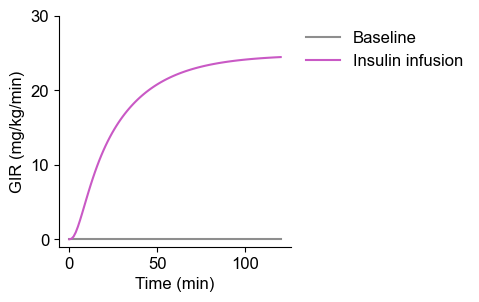

In [15]:
fig, ax = plt.subplots(1,1, figsize=(3,3),)


# Fliter x=for steady state time > 100
x = x[x['time'] > 100]

# Row 1: Intralipid
# Plot simulation
hue_order = ['saline','insulin_low',]

sns.lineplot(data=GIR, x='time', y='GIR', hue ='condition', 
             hue_order=hue_order, ax=ax, err_style="bars", legend=True, palette=palette)

ax.set_ylabel('GIR (mg/kg/min)')
ax.set_xlabel('Time (min)')
ax.set_ylim((-1, 30))

# add a legend outside the plot
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ['Baseline', 'Insulin infusion'], loc='upper left', bbox_to_anchor=(1, 1),frameon=False)
# Add annotations

sns.despine()


/opt/homebrew/Caskroom/miniconda/base/envs/skimpy-env/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/opt/homebrew/Caskroom/miniconda/base/envs/skimpy-env/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])
/opt/homebrew/Caskroom/miniconda/base/envs/skimpy-env/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/opt/homebrew/Caskroom/miniconda/base/envs/skimpy-env/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])
/opt/homebrew/Caskroom/miniconda/base/envs/skimpy-env/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/opt/homebrew/Caskroom/mi

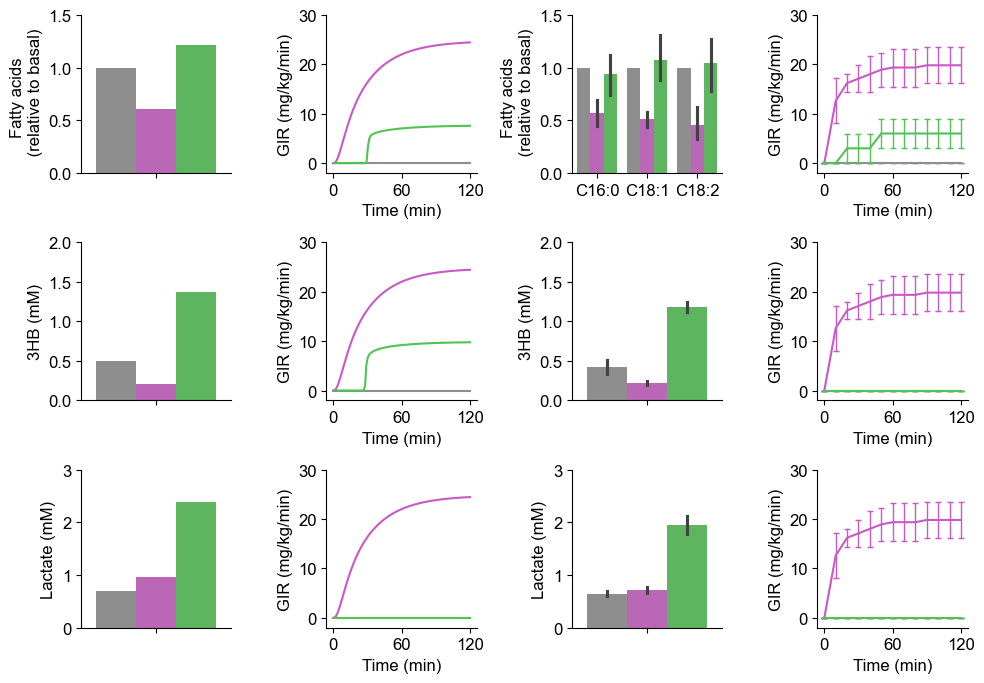

In [16]:
# Make a 3x4 grid to compare infusate concnetration and GIR

fig, axs = plt.subplots(3,4, figsize=(10,7),)


# Fliter x=for steady state time > 100
x = x[x['time'] > 100]

# Row 1: Intralipid
# Plot simulation
hue_order = ['saline','insulin_low',  'insulin_low_intralipid',]

sns.barplot(data=x,  y='F', hue ='condition', hue_order=hue_order, ax=axs[0,0], legend=False, palette=palette)
sns.lineplot(data=GIR, x='time', y='GIR', hue ='condition', 
             hue_order=hue_order, ax=axs[0,1], err_style="bars", legend=False, palette=palette)


# Plot data
# Plot infusate concentration
hue_order = ['Saline', '1.25 mU Insulin', '1.25 mU Insulin + Intralipid',] #'1.25 mU Insulin + 3HB', '1.25 mU Insulin + Lactate']
sns.barplot(data=FFA_clamp_intralipid, x='Species', y='FFA', ax=axs[0,2], hue='variable' , 
            hue_order=hue_order, legend=False, palette=palette)

# Plot GIR
sns.lineplot(data=GIR_clamp_intralipid, x='time', y='GIR', ax=axs[0,3], 
             hue='variable',
             hue_order=hue_order, legend=False, 
             err_style="bars", err_kws=errorbar_kwargs, errorbar='se', palette=palette)


# Row 2: 3HB

# Plot simulation
hue_order = ['saline','insulin_low', 'insulin_low_3HB',]

sns.barplot(data=x,  y='K', hue ='condition', hue_order=hue_order, ax=axs[1,0], legend=False, palette=palette)
sns.lineplot(data=GIR, x='time', y='GIR', hue ='condition', 
             hue_order=hue_order, ax=axs[1,1], err_style="bars", legend=False, 
             palette=palette)

# Plot data
# Plot infusate concentration
hue_order = ['Saline', '1.25 mU Insulin', '1.25 mU Insulin + 3HB',] #'1.25 mU Insulin + Lactate']
sns.barplot(data=_3HB_clamp_3HB,  y='3HB', ax=axs[1,2], hue='variable' , hue_order=hue_order, legend=False, palette=palette)

# Plot GIR
sns.lineplot(data=GIR_clamp_3HB, x='time', y='GIR', ax=axs[1,3], hue='variable' , 
             hue_order=hue_order, legend=False, err_style="bars", 
             err_kws=errorbar_kwargs, errorbar='se', palette=palette)

# Row 3: Lactate

# Plot simulation
hue_order = ['saline','insulin_low', 'insulin_low_lactate',]

sns.barplot(data=x,  y='L', hue ='condition', hue_order=hue_order, ax=axs[2,0], legend=False, palette=palette)
sns.lineplot(data=GIR, x='time', y='GIR', hue ='condition', 
             hue_order=hue_order, ax=axs[2,1], err_style="bars", legend=False, palette=palette)

# Plot data
# Plot infusate concentration
hue_order = ['Saline', '1.25 mU Insulin', '1.25 mU Insulin + Lactate']
sns.barplot(data=lactate_clamp_lactate,  y='lactate', ax=axs[2,2], hue='variable' , 
            hue_order=hue_order, legend=False, palette=palette)

# Plot GIR
sns.lineplot(data=GIR_clamp_lactate, x='time', y='GIR', ax=axs[2,3], hue='variable' , 
             hue_order=hue_order, legend=False, err_style="bars", 
             err_kws=errorbar_kwargs,errorbar='se', palette=palette)

# Axis ylims
for ax in axs[:,1]:
    ax.set_ylim(-2, 30)
for ax in axs[:,3]:
    ax.set_ylim(-2, 30)

# Axis lims 
axs[0,0].set_ylim(0, 1.5)
axs[0,2].set_ylim(0, 1.5)

axs[1,0].set_ylim(0, 2)
axs[1,2].set_ylim(0, 2)

axs[2,0].set_ylim(0, 3)
axs[2,2].set_ylim(0, 3)

# Axis labels

# Y axis labels
axs[0,0].set_ylabel('Fatty acids \n (relative to basal)')
axs[0,1].set_ylabel('GIR (mg/kg/min)')
axs[0,2].set_ylabel('Fatty acids \n (relative to basal)')
axs[0,3].set_ylabel('GIR (mg/kg/min)')

axs[1,0].set_ylabel('3HB (mM)')
axs[1,1].set_ylabel('GIR (mg/kg/min)')
axs[1,2].set_ylabel('3HB (mM)')
axs[1,3].set_ylabel('GIR (mg/kg/min)')

axs[2,0].set_ylabel('Lactate (mM)')
axs[2,1].set_ylabel('GIR (mg/kg/min)')
axs[2,2].set_ylabel('Lactate (mM)')
axs[2,3].set_ylabel('GIR (mg/kg/min)')


# X axis labels
for i in range(3):
    axs[i,0].set_xlabel('')
    axs[i,1].set_xlabel('Time (min)')
    axs[i,2].set_xlabel('')
    axs[i,3].set_xlabel('Time (min)')

    axs[i,1].set_xticks([0, 60, 120])
    axs[i,3].set_xticks([0, 60, 120])


sns.despine()
plt.tight_layout()


# Save the figure
plt.savefig('output/insulin_clamp_simulation.svg', bbox_inches='tight')

/opt/homebrew/Caskroom/miniconda/base/envs/skimpy-env/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/opt/homebrew/Caskroom/miniconda/base/envs/skimpy-env/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])
/opt/homebrew/Caskroom/miniconda/base/envs/skimpy-env/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/opt/homebrew/Caskroom/miniconda/base/envs/skimpy-env/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])
/opt/homebrew/Caskroom/miniconda/base/envs/skimpy-env/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/opt/homebrew/Caskroom/mi

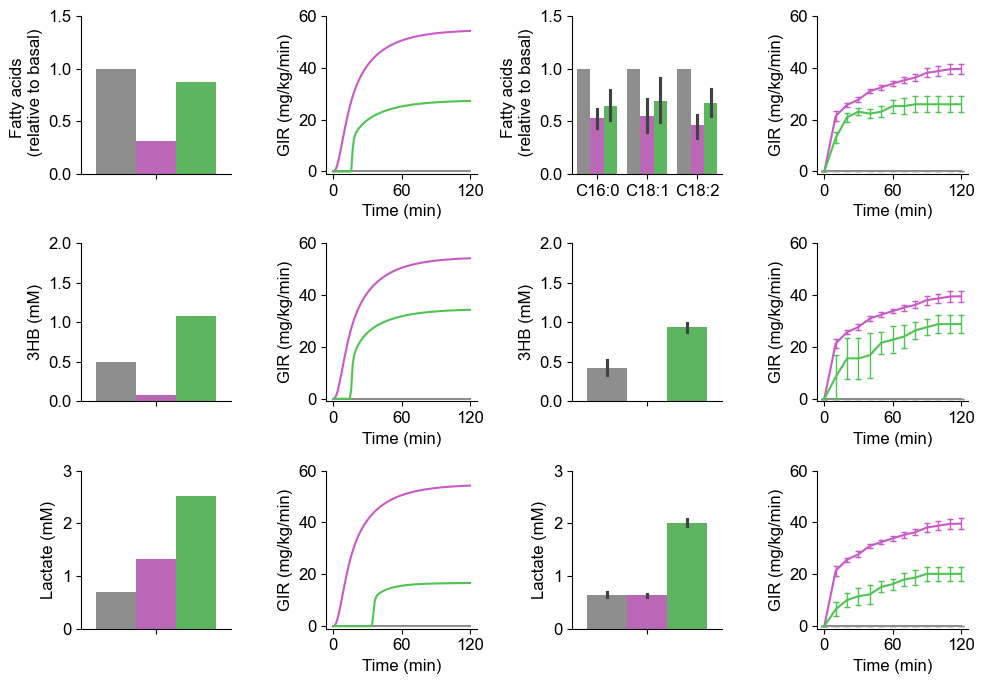

In [17]:
# Make a 3x4 grid to compare infusate concentration and GIR for high insulin (2.5mU)

fig, axs = plt.subplots(3, 4, figsize=(10, 7))


# Filter x for steady state time > 100
x_high = x[x['time'] > 100]

# Row 1: Intralipid
# Plot simulation
hue_order = ['saline', 'insulin_high', 'insulin_high_intralipid']

sns.barplot(data=x_high, y='F', hue='condition', hue_order=hue_order, ax=axs[0, 0], legend=False, palette=palette)
sns.lineplot(data=GIR, x='time', y='GIR', hue='condition', hue_order=hue_order, ax=axs[0, 1], err_style="bars", legend=False, palette=palette)

# Plot data
# Plot infusate concentration
hue_order = ['Saline', '2.5 mU Insulin', '2.5 mU Insulin + Intralipid']
sns.barplot(data=FFA_clamp_intralipid, x='Species', y='FFA', ax=axs[0, 2], hue='variable', hue_order=hue_order, legend=False, palette=palette)

# Plot GIR
sns.lineplot(data=GIR_clamp_intralipid, x='time', y='GIR', ax=axs[0, 3], hue='variable', hue_order=hue_order, legend=False, err_style="bars", err_kws=errorbar_kwargs, markers='o', errorbar='se', palette=palette)

# Row 2: 3HB
# Plot simulation
hue_order = ['saline', 'insulin_high', 'insulin_high_3HB']

sns.barplot(data=x_high, y='K', hue='condition', hue_order=hue_order, ax=axs[1, 0], legend=False, palette=palette)
sns.lineplot(data=GIR, x='time', y='GIR', hue='condition', hue_order=hue_order, ax=axs[1, 1], err_style="bars", legend=False, palette=palette)

# Plot data
# Plot infusate concentration
hue_order = ['Saline', '2.5 mU Insulin', '2.5 mU Insulin + 3HB']
sns.barplot(data=_3HB_clamp_3HB, y='3HB', ax=axs[1, 2], hue='variable', hue_order=hue_order, legend=False, palette=palette)

# Plot GIR
sns.lineplot(data=GIR_clamp_3HB, x='time', y='GIR', ax=axs[1, 3], hue='variable', hue_order=hue_order, legend=False, err_style="bars", err_kws=errorbar_kwargs, markers='o', errorbar='se', palette=palette)

# Row 3: Lactate
# Plot simulation
hue_order = ['saline', 'insulin_high', 'insulin_high_lactate']

sns.barplot(data=x_high, y='L', hue='condition', hue_order=hue_order, ax=axs[2, 0], legend=False, palette=palette)
sns.lineplot(data=GIR, x='time', y='GIR', hue='condition', hue_order=hue_order, ax=axs[2, 1], err_style="bars", legend=False, palette=palette)

# Plot data
# Plot infusate concentration
hue_order = ['Saline', '2.5 mU Insulin', '2.5 mU Insulin + Lactate']
sns.barplot(data=lactate_clamp_lactate, y='lactate', ax=axs[2, 2], hue='variable', hue_order=hue_order, legend=False, palette=palette)

# Plot GIR
sns.lineplot(data=GIR_clamp_lactate, x='time', y='GIR', ax=axs[2, 3], hue='variable', hue_order=hue_order, legend=False, err_style="bars", err_kws=errorbar_kwargs, markers='o', errorbar='se', palette=palette)

# Axis ylims
for ax in axs[:, 1]:
    ax.set_ylim(-1, 60)
for ax in axs[:, 3]:
    ax.set_ylim(-1, 60)

# Axis lims
axs[0, 0].set_ylim(0, 1.5)
axs[0, 2].set_ylim(0, 1.5)

axs[1, 0].set_ylim(0, 2)
axs[1, 2].set_ylim(0, 2)

axs[2, 0].set_ylim(0, 3)
axs[2, 2].set_ylim(0, 3)

# Axis labels
# Y axis labels
axs[0, 0].set_ylabel('Fatty acids \n (relative to basal)')
axs[0, 1].set_ylabel('GIR (mg/kg/min)')
axs[0, 2].set_ylabel('Fatty acids \n (relative to basal)')
axs[0, 3].set_ylabel('GIR (mg/kg/min)')

axs[1, 0].set_ylabel('3HB (mM)')
axs[1, 1].set_ylabel('GIR (mg/kg/min)')
axs[1, 2].set_ylabel('3HB (mM)')
axs[1, 3].set_ylabel('GIR (mg/kg/min)')

axs[2, 0].set_ylabel('Lactate (mM)')
axs[2, 1].set_ylabel('GIR (mg/kg/min)')
axs[2, 2].set_ylabel('Lactate (mM)')
axs[2, 3].set_ylabel('GIR (mg/kg/min)')

# X axis labels
for i in range(3):
    axs[i, 0].set_xlabel('')
    axs[i, 1].set_xlabel('Time (min)')
    axs[i, 2].set_xlabel('')
    axs[i, 3].set_xlabel('Time (min)')

    axs[i, 1].set_xticks([0, 60, 120])
    axs[i, 3].set_xticks([0, 60, 120])

sns.despine()
plt.tight_layout()

# Save the figure
plt.savefig('output/insulin_clamp_simulation_high_insulin.svg', bbox_inches='tight')


In [18]:
x[x.condition == 'insulin_low_lactate']

,L,G,F,K,I,IA,time,condition
83,2.401157,1.053959,0.594940,0.273890,0.121403,0.126788,100.606061,insulin_low_lactate
84,2.399715,1.054083,0.595870,0.274475,0.121415,0.126575,101.818182,insulin_low_lactate
85,2.398396,1.054240,0.596768,0.275048,0.121434,0.126371,103.030303,insulin_low_lactate
86,2.397195,1.054429,0.597633,0.275606,0.121461,0.126176,104.242424,insulin_low_lactate
87,2.396110,1.054647,0.598466,0.276151,0.121494,0.125990,105.454545,insulin_low_lactate
88,2.395135,1.054892,0.599266,0.276680,0.121533,0.125812,106.666667,insulin_low_lactate
89,2.394266,1.055163,0.600033,0.277195,0.121577,0.125644,107.878788,insulin_low_lactate
90,2.393499,1.055457,0.600768,0.277694,0.121627,0.125484,109.090909,insulin_low_lactate
91,2.392831,1.055773,0.601470,0.278178,0.121682,0.125332,110.303030,insulin_low_lactate
92,2.392257,1.056108,0.602140,0.278645,0.121742,0.125189,111.515152,insulin_low_lactate
